<a href="https://colab.research.google.com/github/wimurr/Fashion_MNIST/blob/main/Fashion_MNIST_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
%matplotlib inline

In [2]:
import torch
from torch.utils.data import Dataset,DataLoader
import torch.optim
import PIL # Python Image Library
import torchvision.datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from random import randint

In [3]:
N_EPOCHS = 20
data_dir = Path("./sample_data")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on device {device}.")

Training on device cuda.


In [4]:
FASHION_MNIST_CLASS_NAMES = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle boot'}

# Images
FASHION_MNIST_train = torchvision.datasets.FashionMNIST(root=str(data_dir),train=True,download=True)
FASHION_MNIST_test = torchvision.datasets.FashionMNIST(root=str(data_dir),train=False,download=True)
FASHION_MNIST_image_channels = 1

# Tensors from images
tensor_FASHION_MNIST_train = torchvision.datasets.FashionMNIST(root=str(data_dir),train=True,download=True,transform=ToTensor())
tensor_FASHION_MNIST_test = torchvision.datasets.FashionMNIST(root=str(data_dir),train=False,download=True,transform=ToTensor())


In [5]:
# Utilities to examine the data, show an example, and normalize the results, if desired

def examine_data_set(train=FASHION_MNIST_train,test=FASHION_MNIST_test):
    print(f"There are {len(train)} training data samples and {len(test)} data samples for testing.")

def one_example(class_names=FASHION_MNIST_CLASS_NAMES,train=FASHION_MNIST_train):
    '''Randomly pick one example. Display it if it is an image. Otherwise
    just describe it's shape and label. Either way return the data and label.'''
    N = len(train)
    i = randint(0,N-1)
    data_sample,label = train[i]
    if isinstance(data_sample,PIL.Image.Image):
        print(f"Randomly fetched image train[{i}]. Type is {type(data_sample)}.")
        best_label=class_names[label]
        print(f"Class index = {label}, Label = {best_label}")
        plt.imshow(data_sample)
        plt.show()
        return data_sample,label
    else:
        print(f"Randomly fetched train[{i}] data sample. Type is {type(data_sample)}. Shape is: {data_sample.shape}")
        print(f"It's label is: {label}")
        return data_sample,label

def show_batch_example(train=tensor_FASHION_MNIST_train,N=10):
    train_data_loader = DataLoader(train,batch_size=N,shuffle=True)
    for samples,labels in train_data_loader:
        print(f"We fetched a single batch of {N} randomly selected samples.")
        print(f"The shape of the data batch is: {samples.shape}")
        print(f"The shape of the labels for that batch is: {labels.shape}")
        break

def get_mean_and_std(train=tensor_FASHION_MNIST_train,N_channels=1):

    # Adds a last dimension to count the number of images stacked one upon another
    stacked_images = torch.stack([image_tensor for image_tensor, label in train], dim=3)
    print(f"The stacked images for all of the training data set has shape {stacked_images.shape}.")

    # For each channel, add across the stacked images to get the mean and std
    the_means = stacked_images.view(N_channels,-1).mean(dim=1)
    print("The mean is: ",the_means)
    the_stds = stacked_images.view(N_channels,-1).std(dim=1)
    print("The standard deviation is: ",the_stds)
    return the_means,the_stds


In [6]:
examine_data_set(train=FASHION_MNIST_train,test=FASHION_MNIST_test)

There are 60000 training data samples and 10000 data samples for testing.


In [7]:
show_batch_example(train=tensor_FASHION_MNIST_train,N=3)

We fetched a single batch of 3 randomly selected samples.
The shape of the data batch is: torch.Size([3, 1, 28, 28])
The shape of the labels for that batch is: torch.Size([3])


Randomly fetched image train[53829]. Type is <class 'PIL.Image.Image'>.
Class index = 1, Label = Trouser


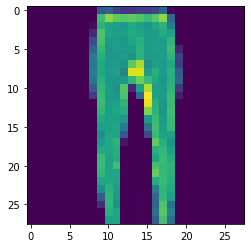

(<PIL.Image.Image image mode=L size=28x28 at 0x7FC898282E10>, 1)

In [8]:
one_example(class_names=FASHION_MNIST_CLASS_NAMES,train=FASHION_MNIST_train)

In [9]:
mean,std = get_mean_and_std(train=tensor_FASHION_MNIST_train,N_channels=1)

The stacked images for all of the training data set has shape torch.Size([1, 28, 28, 60000]).
The mean is:  tensor([0.2860])
The standard deviation is:  tensor([0.3530])


In [10]:
class two_convolutional_layers_two_hidden_layers_model(nn.Module):

    '''Class with TWO hidden layers, also written with functional 
    counterparts for max pooling, activations, and flattening to make
    the definition more concise and to be more clear where parameters
    are important or not.'''

    def __init__(self,input_image_channels,image_size,k_outputs,first_hidden_layer_units=64,second_hidden_layer_units=32):
        super().__init__()
        assert image_size % 4 == 0,f"Image size should be a multiple of 4, not {image_size}."
        self.image_size = image_size
        image_size_after_two_max_pool2ds = int(image_size / 4)
        self.image_size_after_two_max_pool2ds = int(image_size / 4)
        self.first_convolutional_layer = nn.Conv2d(in_channels=input_image_channels,out_channels=64,kernel_size=3,padding=1)
        self.second_convolutional_layer = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,padding=1)
        self.flattening_for_linear = nn.Flatten()
        self.first_hidden_layer = nn.Linear(in_features = 32 * image_size_after_two_max_pool2ds * image_size_after_two_max_pool2ds, out_features = first_hidden_layer_units)
        self.second_hidden_layer = nn.Linear(in_features = first_hidden_layer_units, out_features = second_hidden_layer_units)
        self.output_layer = nn.Linear(in_features = second_hidden_layer_units, out_features = k_outputs)
        self.logits_output_layer = nn.LogSoftmax(dim=1)

    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.first_convolutional_layer(x)), 2)
        out = F.max_pool2d(torch.tanh(self.second_convolutional_layer(out)), 2)   
        out = self.flattening_for_linear(out)
        out = torch.tanh(self.first_hidden_layer(out))
        out = torch.tanh(self.second_hidden_layer(out))
        out = self.output_layer(out)
        out = self.logits_output_layer(out)
        return out

In [11]:
def train_model(training_data_set, validation_data_set,n_input_channels,image_size,n_outputs,
                         epochs=N_EPOCHS,learning_rate=1e-2):
    model = image_neural_net_classifier(n_input_channels,image_size,n_outputs)
    # if we are running on a GPU, move the model over before creating the optimizer,
    # which will grab the model's parameters.
    model = model.to(device=device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.NLLLoss()
    training_loop(training_data_set, validation_data_set, model, loss_fn, optimizer,epochs)    
    return model,optimizer,loss_fn

def image_neural_net_classifier(n_input_channels,image_size,n_outputs,hidden_layer_units=30):
    # small model:
    # model = create_two_convolutional_layer_one_hidden_layer_model(n_input_channels,image_size,n_outputs,hidden_layer_units)
    # large model:
    model = two_convolutional_layers_two_hidden_layers_model(n_input_channels,image_size,n_outputs)
    return model

def training_loop(training_data_set, validation_data_set, model, loss_fn, optimizer,
                            n_epochs=N_EPOCHS,batch_size=64,show_sizes=True):

    start_time = time.time()
    
    # prepare for training
    model.train()

    train_data_loader = DataLoader(training_data_set, batch_size = batch_size, shuffle=True)

    n_images = len(training_data_set)

    for epoch in range(n_epochs):
        loss_for_this_epoch = 0
        for images, labels in train_data_loader:

            if show_sizes and epoch == 0:
                print(f"For one batch, images has shape {images.shape}")
                print(f"For one batch, labels has shape {labels.shape}")

            # run the neural net model on the current batch.
            # after first moving the data to the GPU, if we are
            # running on one.
            images = images.to(device=device)
            labels = labels.to(device=device)
            outputs = model(images)

            # optional tracing
            if show_sizes and epoch == 0:
                print(f"For one batch, outputs has shape {outputs.shape}")
                show_sizes=False

            # find the loss for this batch and update that for the epoch
            batch_loss = loss_fn(outputs, labels)

            # update stats for loss
            loss_for_this_epoch += batch_loss

            # update the model for this batch
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        average_loss = loss_for_this_epoch / len(train_data_loader)
        print(f"Epoch: {epoch}, Average loss per image for this epoch, current batch in training data: {average_loss:.6f}, over {n_images} images.")

        if epoch % 5 == 0:
            validate_accuracy_from_data_sets(model,training_data_set,validation_data_set)

    # Finish by showing accuracy, if we didn't just do that.
    if epoch % 5 != 0:
        validate_accuracy_from_data_sets(model,training_data_set,validation_data_set)    

    end_time = time.time()
    delta_time = end_time - start_time

    # done training, for now at least!
    model.eval()

    if n_epochs > 0:
        print(f"Finished in {delta_time:.2f} seconds, or {delta_time/n_epochs:.2f} seconds / epoch.")

def validate_accuracy_from_data_sets(model,training_data_set,validation_data_set,batch_size=64):
    print("Checking accuracy...")
    train_loader = DataLoader(training_data_set, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(validation_data_set, batch_size = batch_size, shuffle=True)    
    validate_accuracy(model,train_loader,val_loader)

def validate_accuracy(model, train_loader, val_loader):
    for name, loader in [("Train",train_loader),("Validation",val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in loader:

                # run the neural net model on the current batch.
                # after first moving the data to the GPU, if we are
                # running on one.
                images = images.to(device=device)
                labels = labels.to(device=device)

                outputs = model(images)
                _, predicted = torch.max(outputs, dim=1)

                total += labels.shape[0]
                correct += int((predicted == labels).sum())

            print(f"Accuracy on {name} Set: {correct / total:.2f}")


def run_model(model,class_names,validation_set,original_image_set,n=5):
    '''Pick N examples from the validation set
    and display them using the corresponding original image set'''
    print(f"\nShowing {n} examples of model performance, taken randomly from the validation set.\n")
    for i in range(n):
        tensor_from_image,label = validation_set[i]
        best_class_name = class_names[label]
        print(f"Image {i}. Correct label = {best_class_name}, Class Index = {label}")
        prediction = run_one_data_sample_with_model(model,tensor_from_image)
        probabilities = prediction.exp()
        print(f"Prediction: {probabilities}")
        print_image_and_prediction_details(class_names,prediction,probabilities,original_image_set,i)

def run_one_data_sample_with_model(model,tensor_data_sample):
    '''Takes a single data sample and returns the model output,
    typical a log softmax, for the single data sample. Handles
    the bundling and unbundling of the data sample into and
    out of a one-element minibatch.'''
    #  add [] around data sample with unsqueeze to turn it into a single minibatch
    singleton_batch_input = tensor_data_sample.unsqueeze(0)
    with torch.no_grad():
        model = model.to(device)
        batch_of_one_image_tensor = singleton_batch_input.to(device)
        singleton_batch_output = model(batch_of_one_image_tensor)
        output = singleton_batch_output.detach() # note the returned tensor still shares memory w the original
        output = output.squeeze(0)               # unbundle from minibatch of outputs, remove []
        return output.to('cpu')

def print_image_and_prediction_details(class_names,prediction,probabilities,original_image_set,index):
    print_image_class(class_names,prediction,probabilities)
    show_original_image(original_image_set,index)
    print_class_predicted(class_names,probabilities)

def print_image_class(class_names,prediction,probabilities):
    print(f"Predictions: {prediction}")
    print_class_probabilities(class_names,probabilities)

def show_original_image(original_image_set,index):
    original_image,_ = original_image_set[index]
    plt.imshow(original_image)
    plt.show()

In [12]:

def print_class_predicted(class_names,probabilities):
    best_index,predicted_label = best_class_prediction(class_names,probabilities)
    print(f"Predicted Label = {predicted_label}, Class Index = {best_index}\n")

def show_mistakes(model,class_names,validation_set,original_image_set,n=10):
    '''Show the first N mistakes found from the validation set
    and display them using the corresponding original image set'''
    i = 0
    print(f"\nFinding {n} examples where the model predicted incorrectly.\n")
    mistakes_found = 0
    max_i = len(validation_set)
    while i < max_i and mistakes_found < n:
        tensor_from_image,label = validation_set[i] # label is the index of the classes and indicates the correct class
        prediction = run_one_data_sample_with_model(model,tensor_from_image)
        probabilities = prediction.exp()
        best_index,predicted_label = best_class_prediction(class_names,probabilities)
        if best_index != label:
            mistakes_found += 1
            correct_class_name = class_names[label]
            print(f"\nMistake {mistakes_found}. Image {i}. Correct Label = {correct_class_name}, Class Index {label}. Predicted: {predicted_label}, Class Index {best_index}. Oops!")
            print_image_and_prediction_details(class_names,prediction,probabilities,original_image_set,i)
            if mistakes_found >= n:
                print(f"Found {mistakes_found} mistakes after examining {i} images.")
                return mistakes_found
        i += 1
    print(f"Found {mistakes_found} mistakes total, could not find {n}, after examining {i} images.")        
    return mistakes_found
        
def print_class_probabilities(class_names,probs):
    for name,prob in zip(class_names,probs):
        print(f"Class {name}: {prob:.2%}")

def best_class_prediction(class_names,probs,show_details=False):
    highest_class_prob,best_index = probs.max(dim=0)
    highest_class_prob,best_index = highest_class_prob.numpy(),best_index.numpy()
    highest_class_prob,best_class_index = float(highest_class_prob),int(best_index)
    if show_details:
        print(f"Best class index for the label is class {best_class_index} with probability {highest_class_prob:.2%}")
    best_class_name = class_names[best_class_index]
    return best_class_index,best_class_name


In [13]:
def train_Fashion_MNIST_model():
    input_channels = 1
    n_outputs = 10
    image_size = 28
    model,_,_ =  train_model(tensor_FASHION_MNIST_train,tensor_FASHION_MNIST_test,input_channels,image_size,n_outputs)
    class_names = FASHION_MNIST_CLASS_NAMES
    return model

def show_Fashion_MNIST_demo(model):
    model.eval()

    class_names = FASHION_MNIST_CLASS_NAMES
    
    # show 5 random examples of the model runningup
    run_model(model,class_names,tensor_FASHION_MNIST_test,FASHION_MNIST_test,n=5)

    # show 5 examples of when it predicts the incorrect result
    show_mistakes(model,class_names,tensor_FASHION_MNIST_test,FASHION_MNIST_test,n=25)


In [14]:
trained_model = train_Fashion_MNIST_model()

For one batch, images has shape torch.Size([64, 1, 28, 28])
For one batch, labels has shape torch.Size([64])
For one batch, outputs has shape torch.Size([64, 10])
Epoch: 0, Average loss per image for this epoch, current batch in training data: 1.390850, over 60000 images.
Checking accuracy...
Accuracy on Train Set: 0.71
Accuracy on Validation Set: 0.70
Epoch: 1, Average loss per image for this epoch, current batch in training data: 0.729382, over 60000 images.
Epoch: 2, Average loss per image for this epoch, current batch in training data: 0.576114, over 60000 images.
Epoch: 3, Average loss per image for this epoch, current batch in training data: 0.503658, over 60000 images.
Epoch: 4, Average loss per image for this epoch, current batch in training data: 0.455865, over 60000 images.
Epoch: 5, Average loss per image for this epoch, current batch in training data: 0.420778, over 60000 images.
Checking accuracy...
Accuracy on Train Set: 0.86
Accuracy on Validation Set: 0.85
Epoch: 6, Ave


Showing 5 examples of model performance, taken randomly from the validation set.

Image 0. Correct label = Ankle boot, Class Index = 9
Prediction: tensor([9.4568e-06, 2.8169e-04, 8.6360e-06, 1.6466e-04, 2.3147e-04, 5.1614e-03,
        2.9117e-05, 9.1985e-03, 1.3895e-03, 9.8353e-01])
Predictions: tensor([-11.5688,  -8.1747, -11.6596,  -8.7116,  -8.3711,  -5.2666, -10.4442,
         -4.6887,  -6.5788,  -0.0166])
Class 0: 0.00%
Class 1: 0.03%
Class 2: 0.00%
Class 3: 0.02%
Class 4: 0.02%
Class 5: 0.52%
Class 6: 0.00%
Class 7: 0.92%
Class 8: 0.14%
Class 9: 98.35%


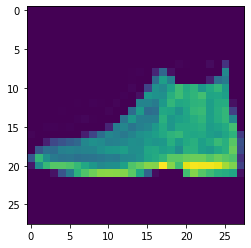

Predicted Label = Ankle boot, Class Index = 9

Image 1. Correct label = Pullover, Class Index = 2
Prediction: tensor([2.1223e-03, 1.4244e-04, 9.8902e-01, 8.6067e-05, 4.2765e-03, 1.4440e-04,
        4.0182e-03, 4.2821e-06, 1.8744e-04, 2.3685e-06])
Predictions: tensor([-6.1553e+00, -8.8566e+00, -1.1045e-02, -9.3604e+00, -5.4546e+00,
        -8.8429e+00, -5.5169e+00, -1.2361e+01, -8.5821e+00, -1.2953e+01])
Class 0: 0.21%
Class 1: 0.01%
Class 2: 98.90%
Class 3: 0.01%
Class 4: 0.43%
Class 5: 0.01%
Class 6: 0.40%
Class 7: 0.00%
Class 8: 0.02%
Class 9: 0.00%


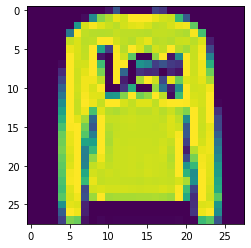

Predicted Label = Pullover, Class Index = 2

Image 2. Correct label = Trouser, Class Index = 1
Prediction: tensor([7.0049e-04, 9.9752e-01, 5.8863e-05, 5.0382e-04, 4.2938e-04, 4.2662e-05,
        2.7204e-05, 4.7887e-04, 3.0824e-05, 2.0960e-04])
Predictions: tensor([-7.2637e+00, -2.4849e-03, -9.7403e+00, -7.5933e+00, -7.7532e+00,
        -1.0062e+01, -1.0512e+01, -7.6441e+00, -1.0387e+01, -8.4703e+00])
Class 0: 0.07%
Class 1: 99.75%
Class 2: 0.01%
Class 3: 0.05%
Class 4: 0.04%
Class 5: 0.00%
Class 6: 0.00%
Class 7: 0.05%
Class 8: 0.00%
Class 9: 0.02%


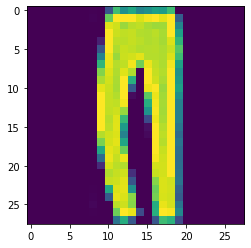

Predicted Label = Trouser, Class Index = 1

Image 3. Correct label = Trouser, Class Index = 1
Prediction: tensor([1.3674e-04, 9.9797e-01, 4.5380e-05, 9.3084e-04, 3.5193e-04, 1.8738e-05,
        6.6710e-06, 2.5886e-04, 4.9005e-06, 2.7358e-04])
Predictions: tensor([-8.8974e+00, -2.0297e-03, -1.0000e+01, -6.9794e+00, -7.9521e+00,
        -1.0885e+01, -1.1918e+01, -8.2592e+00, -1.2226e+01, -8.2039e+00])
Class 0: 0.01%
Class 1: 99.80%
Class 2: 0.00%
Class 3: 0.09%
Class 4: 0.04%
Class 5: 0.00%
Class 6: 0.00%
Class 7: 0.03%
Class 8: 0.00%
Class 9: 0.03%


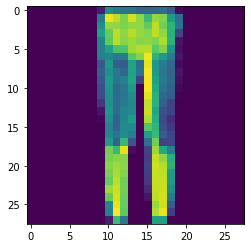

Predicted Label = Trouser, Class Index = 1

Image 4. Correct label = Shirt, Class Index = 6
Prediction: tensor([7.6977e-02, 5.6695e-05, 1.0848e-02, 1.9680e-03, 1.3109e-03, 5.9012e-05,
        9.0811e-01, 1.3407e-05, 6.5413e-04, 1.9600e-06])
Predictions: tensor([ -2.5642,  -9.7778,  -4.5238,  -6.2307,  -6.6371,  -9.7378,  -0.0964,
        -11.2197,  -7.3322, -13.1425])
Class 0: 7.70%
Class 1: 0.01%
Class 2: 1.08%
Class 3: 0.20%
Class 4: 0.13%
Class 5: 0.01%
Class 6: 90.81%
Class 7: 0.00%
Class 8: 0.07%
Class 9: 0.00%


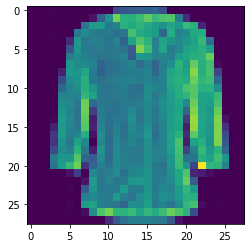

Predicted Label = Shirt, Class Index = 6


Finding 25 examples where the model predicted incorrectly.


Mistake 1. Image 12. Correct Label = Sneaker, Class Index 7. Predicted: Sandal, Class Index 5. Oops!
Predictions: tensor([-7.9549, -5.9190, -7.1017, -5.4477, -6.7735, -0.6383, -9.5646, -1.0113,
        -2.4297, -4.5473])
Class 0: 0.04%
Class 1: 0.27%
Class 2: 0.08%
Class 3: 0.43%
Class 4: 0.11%
Class 5: 52.82%
Class 6: 0.01%
Class 7: 36.37%
Class 8: 8.81%
Class 9: 1.06%


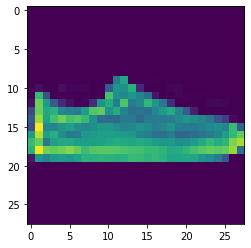

Predicted Label = Sandal, Class Index = 5


Mistake 2. Image 21. Correct Label = Sandal, Class Index 5. Predicted: Sneaker, Class Index 7. Oops!
Predictions: tensor([-9.3441, -6.6837, -8.8651, -7.3140, -7.6276, -1.0884, -9.3906, -0.4455,
        -4.7359, -4.4867])
Class 0: 0.01%
Class 1: 0.13%
Class 2: 0.01%
Class 3: 0.07%
Class 4: 0.05%
Class 5: 33.67%
Class 6: 0.01%
Class 7: 64.05%
Class 8: 0.88%
Class 9: 1.13%


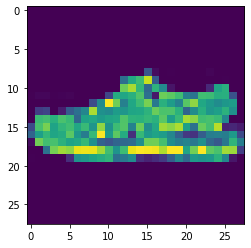

Predicted Label = Sneaker, Class Index = 7


Mistake 3. Image 23. Correct Label = Ankle boot, Class Index 9. Predicted: Sandal, Class Index 5. Oops!
Predictions: tensor([-1.1079e+01, -9.4933e+00, -1.0813e+01, -1.0326e+01, -1.1864e+01,
        -4.9031e-03, -1.0761e+01, -6.4952e+00, -7.9168e+00, -5.8625e+00])
Class 0: 0.00%
Class 1: 0.01%
Class 2: 0.00%
Class 3: 0.00%
Class 4: 0.00%
Class 5: 99.51%
Class 6: 0.00%
Class 7: 0.15%
Class 8: 0.04%
Class 9: 0.28%


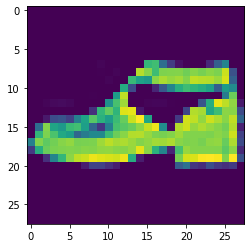

Predicted Label = Sandal, Class Index = 5


Mistake 4. Image 25. Correct Label = Coat, Class Index 4. Predicted: Pullover, Class Index 2. Oops!
Predictions: tensor([ -5.1894,  -7.6363,  -0.4516,  -6.9566,  -2.3907,  -7.1329,  -1.3418,
        -10.8558,  -5.9459, -10.9503])
Class 0: 0.56%
Class 1: 0.05%
Class 2: 63.66%
Class 3: 0.10%
Class 4: 9.16%
Class 5: 0.08%
Class 6: 26.14%
Class 7: 0.00%
Class 8: 0.26%
Class 9: 0.00%


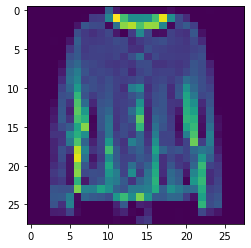

Predicted Label = Pullover, Class Index = 2


Mistake 5. Image 40. Correct Label = Shirt, Class Index 6. Predicted: T-shirt/top, Class Index 0. Oops!
Predictions: tensor([ -0.3506,  -9.2273,  -6.0270,  -7.1641,  -8.2618, -11.0156,  -1.2358,
        -10.5690,  -6.4846, -11.7584])
Class 0: 70.43%
Class 1: 0.01%
Class 2: 0.24%
Class 3: 0.08%
Class 4: 0.03%
Class 5: 0.00%
Class 6: 29.06%
Class 7: 0.00%
Class 8: 0.15%
Class 9: 0.00%


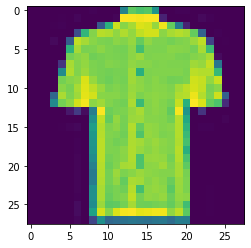

Predicted Label = T-shirt/top, Class Index = 0


Mistake 6. Image 42. Correct Label = Dress, Class Index 3. Predicted: T-shirt/top, Class Index 0. Oops!
Predictions: tensor([ -0.5108,  -4.8329,  -4.3460,  -1.8745,  -5.3448,  -8.6282,  -1.5185,
         -8.1495,  -6.6341, -11.1431])
Class 0: 60.00%
Class 1: 0.80%
Class 2: 1.30%
Class 3: 15.34%
Class 4: 0.48%
Class 5: 0.02%
Class 6: 21.90%
Class 7: 0.03%
Class 8: 0.13%
Class 9: 0.00%


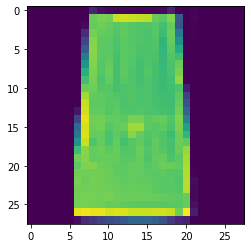

Predicted Label = T-shirt/top, Class Index = 0


Mistake 7. Image 49. Correct Label = Pullover, Class Index 2. Predicted: Shirt, Class Index 6. Oops!
Predictions: tensor([ -3.2352,  -9.1083,  -1.6603,  -4.9528,  -4.2461,  -6.3574,  -0.3030,
        -11.0103,  -4.7428, -11.3121])
Class 0: 3.94%
Class 1: 0.01%
Class 2: 19.01%
Class 3: 0.71%
Class 4: 1.43%
Class 5: 0.17%
Class 6: 73.86%
Class 7: 0.00%
Class 8: 0.87%
Class 9: 0.00%


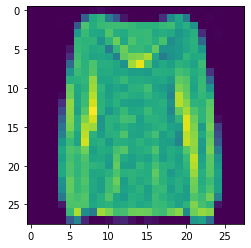

Predicted Label = Shirt, Class Index = 6


Mistake 8. Image 51. Correct Label = Coat, Class Index 4. Predicted: Shirt, Class Index 6. Oops!
Predictions: tensor([ -5.8838,  -7.7727,  -1.1764,  -7.3261,  -1.0795,  -8.1903,  -1.0630,
        -10.0845,  -6.1218,  -9.7054])
Class 0: 0.28%
Class 1: 0.04%
Class 2: 30.84%
Class 3: 0.07%
Class 4: 33.98%
Class 5: 0.03%
Class 6: 34.54%
Class 7: 0.00%
Class 8: 0.22%
Class 9: 0.01%


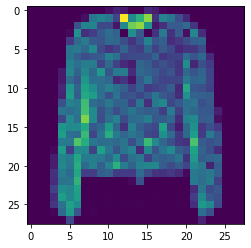

Predicted Label = Shirt, Class Index = 6


Mistake 9. Image 66. Correct Label = Pullover, Class Index 2. Predicted: T-shirt/top, Class Index 0. Oops!
Predictions: tensor([ -1.1557,  -3.6495,  -2.2315,  -1.1766,  -4.0637,  -5.9626,  -1.5099,
         -7.8614,  -6.0528, -10.2671])
Class 0: 31.48%
Class 1: 2.60%
Class 2: 10.74%
Class 3: 30.83%
Class 4: 1.72%
Class 5: 0.26%
Class 6: 22.09%
Class 7: 0.04%
Class 8: 0.24%
Class 9: 0.00%


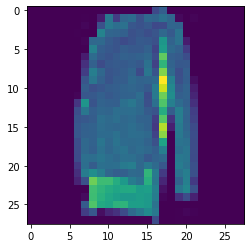

Predicted Label = T-shirt/top, Class Index = 0


Mistake 10. Image 68. Correct Label = Ankle boot, Class Index 9. Predicted: Sneaker, Class Index 7. Oops!
Predictions: tensor([-10.7224,  -7.7717, -11.0031,  -8.5203,  -8.0796,  -4.9170, -10.3665,
         -0.0231,  -6.8833,  -4.3086])
Class 0: 0.00%
Class 1: 0.04%
Class 2: 0.00%
Class 3: 0.02%
Class 4: 0.03%
Class 5: 0.73%
Class 6: 0.00%
Class 7: 97.72%
Class 8: 0.10%
Class 9: 1.35%


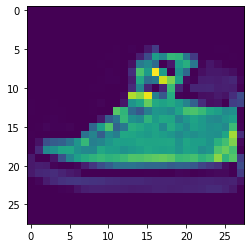

Predicted Label = Sneaker, Class Index = 7


Mistake 11. Image 89. Correct Label = Shirt, Class Index 6. Predicted: Pullover, Class Index 2. Oops!
Predictions: tensor([ -3.4731,  -8.7365,  -0.6511,  -5.7968,  -5.3299,  -6.9226,  -0.8340,
        -11.5205,  -5.4829, -11.1799])
Class 0: 3.10%
Class 1: 0.02%
Class 2: 52.15%
Class 3: 0.30%
Class 4: 0.48%
Class 5: 0.10%
Class 6: 43.43%
Class 7: 0.00%
Class 8: 0.42%
Class 9: 0.00%


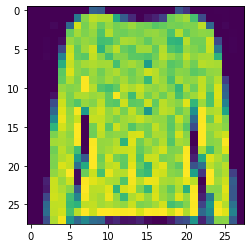

Predicted Label = Pullover, Class Index = 2


Mistake 12. Image 98. Correct Label = Coat, Class Index 4. Predicted: Pullover, Class Index 2. Oops!
Predictions: tensor([-4.4847, -6.1672, -0.2114, -4.9752, -2.3980, -6.0395, -2.7943, -8.9113,
        -4.1755, -8.0903])
Class 0: 1.13%
Class 1: 0.21%
Class 2: 80.95%
Class 3: 0.69%
Class 4: 9.09%
Class 5: 0.24%
Class 6: 6.12%
Class 7: 0.01%
Class 8: 1.54%
Class 9: 0.03%


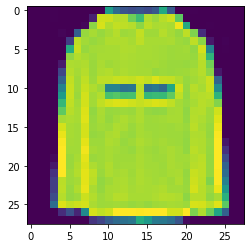

Predicted Label = Pullover, Class Index = 2


Mistake 13. Image 103. Correct Label = Pullover, Class Index 2. Predicted: Shirt, Class Index 6. Oops!
Predictions: tensor([ -2.6479,  -8.1888,  -1.1531,  -5.4307,  -4.7820,  -7.8355,  -0.5127,
        -11.3724,  -6.7336, -12.1312])
Class 0: 7.08%
Class 1: 0.03%
Class 2: 31.57%
Class 3: 0.44%
Class 4: 0.84%
Class 5: 0.04%
Class 6: 59.89%
Class 7: 0.00%
Class 8: 0.12%
Class 9: 0.00%


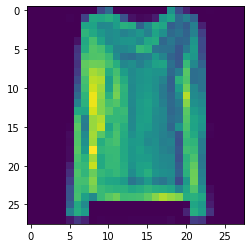

Predicted Label = Shirt, Class Index = 6


Mistake 14. Image 107. Correct Label = Ankle boot, Class Index 9. Predicted: Sneaker, Class Index 7. Oops!
Predictions: tensor([-9.3222, -6.8607, -9.2881, -7.9284, -6.5926, -4.8426, -9.3534, -0.2917,
        -4.1549, -1.4854])
Class 0: 0.01%
Class 1: 0.10%
Class 2: 0.01%
Class 3: 0.04%
Class 4: 0.14%
Class 5: 0.79%
Class 6: 0.01%
Class 7: 74.70%
Class 8: 1.57%
Class 9: 22.64%


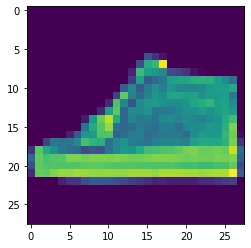

Predicted Label = Sneaker, Class Index = 7


Mistake 15. Image 127. Correct Label = Coat, Class Index 4. Predicted: Pullover, Class Index 2. Oops!
Predictions: tensor([-6.2132, -7.4254, -0.6402, -7.4773, -0.9124, -8.9521, -2.7168, -9.5407,
        -6.3336, -9.9573])
Class 0: 0.20%
Class 1: 0.06%
Class 2: 52.72%
Class 3: 0.06%
Class 4: 40.16%
Class 5: 0.01%
Class 6: 6.61%
Class 7: 0.01%
Class 8: 0.18%
Class 9: 0.00%


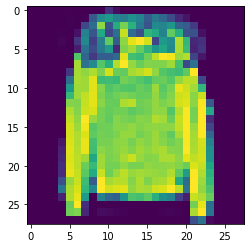

Predicted Label = Pullover, Class Index = 2


Mistake 16. Image 147. Correct Label = Shirt, Class Index 6. Predicted: Dress, Class Index 3. Oops!
Predictions: tensor([ -5.3264,  -5.9606,  -8.1644,  -0.0114,  -6.3418, -11.1624,  -6.5069,
         -9.7178,  -8.2023,  -9.8893])
Class 0: 0.49%
Class 1: 0.26%
Class 2: 0.03%
Class 3: 98.86%
Class 4: 0.18%
Class 5: 0.00%
Class 6: 0.15%
Class 7: 0.01%
Class 8: 0.03%
Class 9: 0.01%


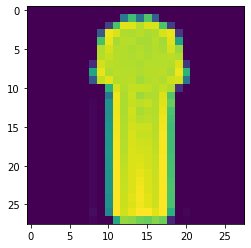

Predicted Label = Dress, Class Index = 3


Mistake 17. Image 150. Correct Label = Coat, Class Index 4. Predicted: Dress, Class Index 3. Oops!
Predictions: tensor([ -2.8497,  -5.9227,  -1.9726,  -0.4202,  -3.0835,  -7.0151,  -2.4117,
         -8.1980,  -4.9903, -10.2842])
Class 0: 5.79%
Class 1: 0.27%
Class 2: 13.91%
Class 3: 65.69%
Class 4: 4.58%
Class 5: 0.09%
Class 6: 8.97%
Class 7: 0.03%
Class 8: 0.68%
Class 9: 0.00%


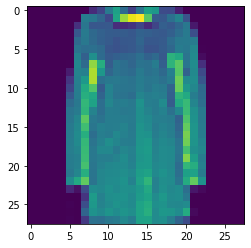

Predicted Label = Dress, Class Index = 3


Mistake 18. Image 153. Correct Label = Coat, Class Index 4. Predicted: Dress, Class Index 3. Oops!
Predictions: tensor([-5.4397, -5.9761, -4.2350, -0.3268, -1.4831, -8.3855, -3.5931, -8.5142,
        -6.0196, -8.9886])
Class 0: 0.43%
Class 1: 0.25%
Class 2: 1.45%
Class 3: 72.12%
Class 4: 22.69%
Class 5: 0.02%
Class 6: 2.75%
Class 7: 0.02%
Class 8: 0.24%
Class 9: 0.01%


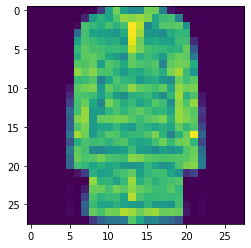

Predicted Label = Dress, Class Index = 3


Mistake 19. Image 172. Correct Label = Pullover, Class Index 2. Predicted: Shirt, Class Index 6. Oops!
Predictions: tensor([ -5.3532,  -7.6170,  -1.5646,  -4.9400,  -1.6659,  -7.5415,  -0.5325,
        -11.3869,  -6.4608,  -8.5568])
Class 0: 0.47%
Class 1: 0.05%
Class 2: 20.92%
Class 3: 0.72%
Class 4: 18.90%
Class 5: 0.05%
Class 6: 58.71%
Class 7: 0.00%
Class 8: 0.16%
Class 9: 0.02%


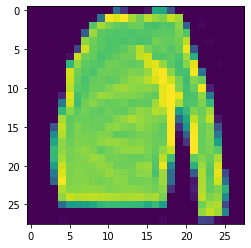

Predicted Label = Shirt, Class Index = 6


Mistake 20. Image 227. Correct Label = Pullover, Class Index 2. Predicted: Shirt, Class Index 6. Oops!
Predictions: tensor([ -3.9799,  -8.5167,  -0.8955,  -6.0485,  -3.5723,  -7.9627,  -0.6154,
        -11.4107,  -6.5148, -11.7200])
Class 0: 1.87%
Class 1: 0.02%
Class 2: 40.84%
Class 3: 0.24%
Class 4: 2.81%
Class 5: 0.03%
Class 6: 54.04%
Class 7: 0.00%
Class 8: 0.15%
Class 9: 0.00%


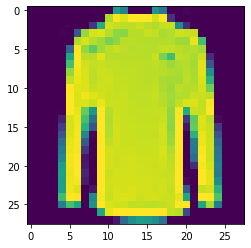

Predicted Label = Shirt, Class Index = 6


Mistake 21. Image 239. Correct Label = Coat, Class Index 4. Predicted: Pullover, Class Index 2. Oops!
Predictions: tensor([-5.8314, -5.4752, -0.1533, -8.3154, -2.5598, -7.8169, -2.8754, -9.5480,
        -7.6791, -9.1939])
Class 0: 0.29%
Class 1: 0.42%
Class 2: 85.79%
Class 3: 0.02%
Class 4: 7.73%
Class 5: 0.04%
Class 6: 5.64%
Class 7: 0.01%
Class 8: 0.05%
Class 9: 0.01%


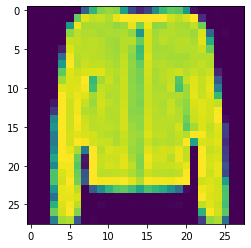

Predicted Label = Pullover, Class Index = 2


Mistake 22. Image 244. Correct Label = Shirt, Class Index 6. Predicted: Pullover, Class Index 2. Oops!
Predictions: tensor([ -6.4826,  -8.3749,  -0.0659,  -7.6520,  -3.6942,  -8.9021,  -3.3121,
        -12.5341,  -8.9417, -11.8156])
Class 0: 0.15%
Class 1: 0.02%
Class 2: 93.62%
Class 3: 0.05%
Class 4: 2.49%
Class 5: 0.01%
Class 6: 3.64%
Class 7: 0.00%
Class 8: 0.01%
Class 9: 0.00%


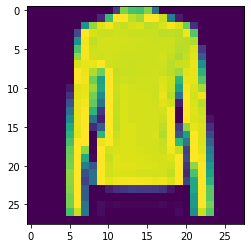

Predicted Label = Pullover, Class Index = 2


Mistake 23. Image 248. Correct Label = Pullover, Class Index 2. Predicted: Shirt, Class Index 6. Oops!
Predictions: tensor([ -3.7653,  -9.0325,  -1.2340,  -5.5411,  -3.6443,  -5.1403,  -0.4743,
        -10.5067,  -3.6015, -10.5333])
Class 0: 2.32%
Class 1: 0.01%
Class 2: 29.11%
Class 3: 0.39%
Class 4: 2.61%
Class 5: 0.59%
Class 6: 62.23%
Class 7: 0.00%
Class 8: 2.73%
Class 9: 0.00%


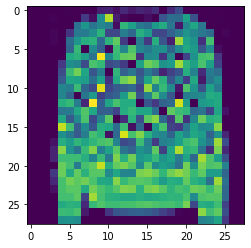

Predicted Label = Shirt, Class Index = 6


Mistake 24. Image 313. Correct Label = Coat, Class Index 4. Predicted: Shirt, Class Index 6. Oops!
Predictions: tensor([ -6.6161, -10.1994,  -3.6677,  -7.4900,  -1.6386,  -9.9002,  -0.2522,
        -11.1306,  -6.8231, -11.0087])
Class 0: 0.13%
Class 1: 0.00%
Class 2: 2.55%
Class 3: 0.06%
Class 4: 19.43%
Class 5: 0.01%
Class 6: 77.71%
Class 7: 0.00%
Class 8: 0.11%
Class 9: 0.00%


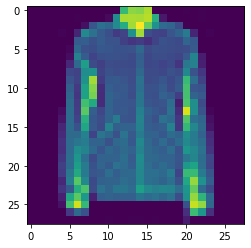

Predicted Label = Shirt, Class Index = 6


Mistake 25. Image 316. Correct Label = Ankle boot, Class Index 9. Predicted: Sneaker, Class Index 7. Oops!
Predictions: tensor([ -9.0356,  -7.2731, -10.9009,  -8.9367,  -7.6566,  -6.9428,  -9.8265,
         -0.0895,  -4.9854,  -2.5730])
Class 0: 0.01%
Class 1: 0.07%
Class 2: 0.00%
Class 3: 0.01%
Class 4: 0.05%
Class 5: 0.10%
Class 6: 0.01%
Class 7: 91.44%
Class 8: 0.68%
Class 9: 7.63%


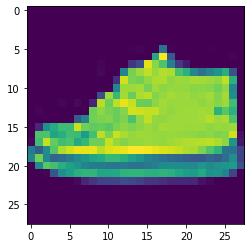

Predicted Label = Sneaker, Class Index = 7

Found 25 mistakes after examining 316 images.


In [15]:
device = 'cuda'
show_Fashion_MNIST_demo(trained_model)